# Greeks and Risk Analysis

This notebook explores:
1. Greeks calculation and verification
2. Delta hedging simulation
3. P&L distribution analysis
4. VaR and CVaR computation

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pricers.black_scholes import BlackScholesPricer
from models.gbm import GBMModel
from risk.var_cvar import RiskMetrics

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Greeks Surface Visualization

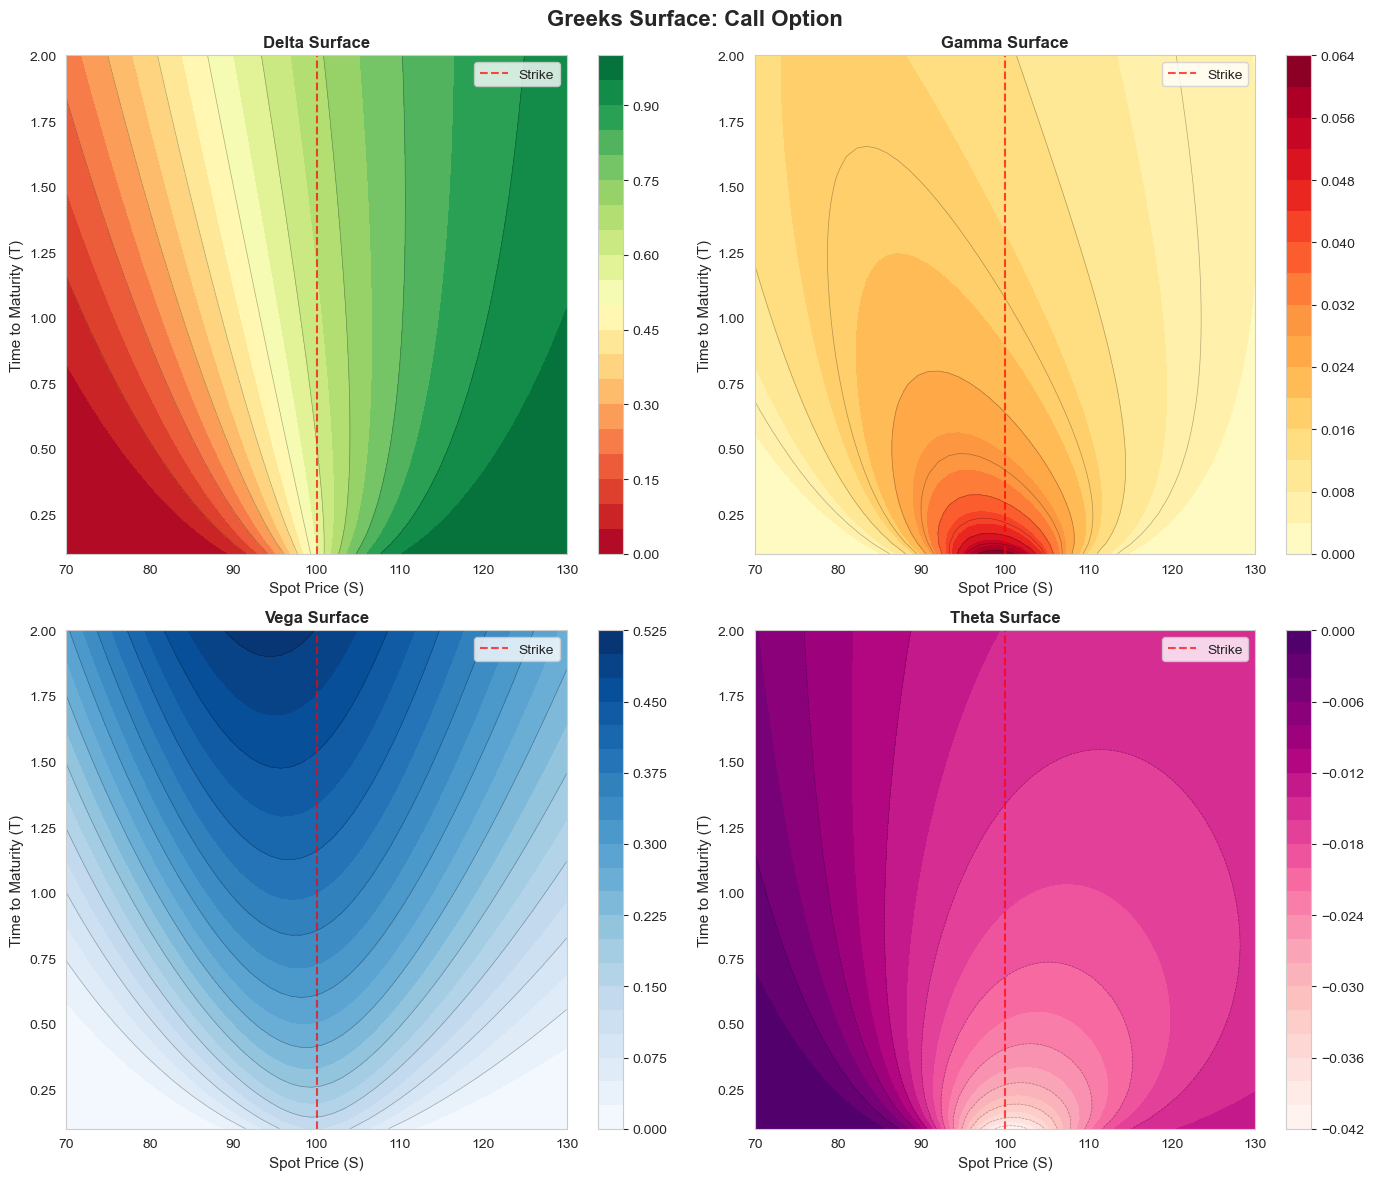

In [2]:
# Parameters
K = 100.0
T = 1.0
r = 0.05
sigma = 0.2
q = 0.0

# Create grid
S_range = np.linspace(70, 130, 50)
time_range = np.linspace(0.1, 2.0, 50)
S_grid, T_grid = np.meshgrid(S_range, time_range)

# Calculate Greeks
delta_grid = np.zeros_like(S_grid)
gamma_grid = np.zeros_like(S_grid)
vega_grid = np.zeros_like(S_grid)
theta_grid = np.zeros_like(S_grid)

for i in range(len(time_range)):
    for j in range(len(S_range)):
        bs = BlackScholesPricer(S_range[j], K, time_range[i], r, sigma, q)
        delta_grid[i, j] = bs.delta('call')
        gamma_grid[i, j] = bs.gamma()
        vega_grid[i, j] = bs.vega()
        theta_grid[i, j] = bs.theta('call')

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Greeks Surface: Call Option', fontsize=16, fontweight='bold')

greeks = [
    (delta_grid, 'Delta', 'RdYlGn'),
    (gamma_grid, 'Gamma', 'YlOrRd'),
    (vega_grid, 'Vega', 'Blues'),
    (theta_grid, 'Theta', 'RdPu')
]

for ax, (data, name, cmap) in zip(axes.flat, greeks):
    c = ax.contourf(S_grid, T_grid, data, levels=20, cmap=cmap)
    ax.contour(S_grid, T_grid, data, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax.axvline(K, color='red', linestyle='--', alpha=0.7, label='Strike')
    ax.set_xlabel('Spot Price (S)', fontsize=11)
    ax.set_ylabel('Time to Maturity (T)', fontsize=11)
    ax.set_title(f'{name} Surface', fontsize=12, fontweight='bold')
    ax.legend()
    plt.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

## 2. Delta Hedging Simulation

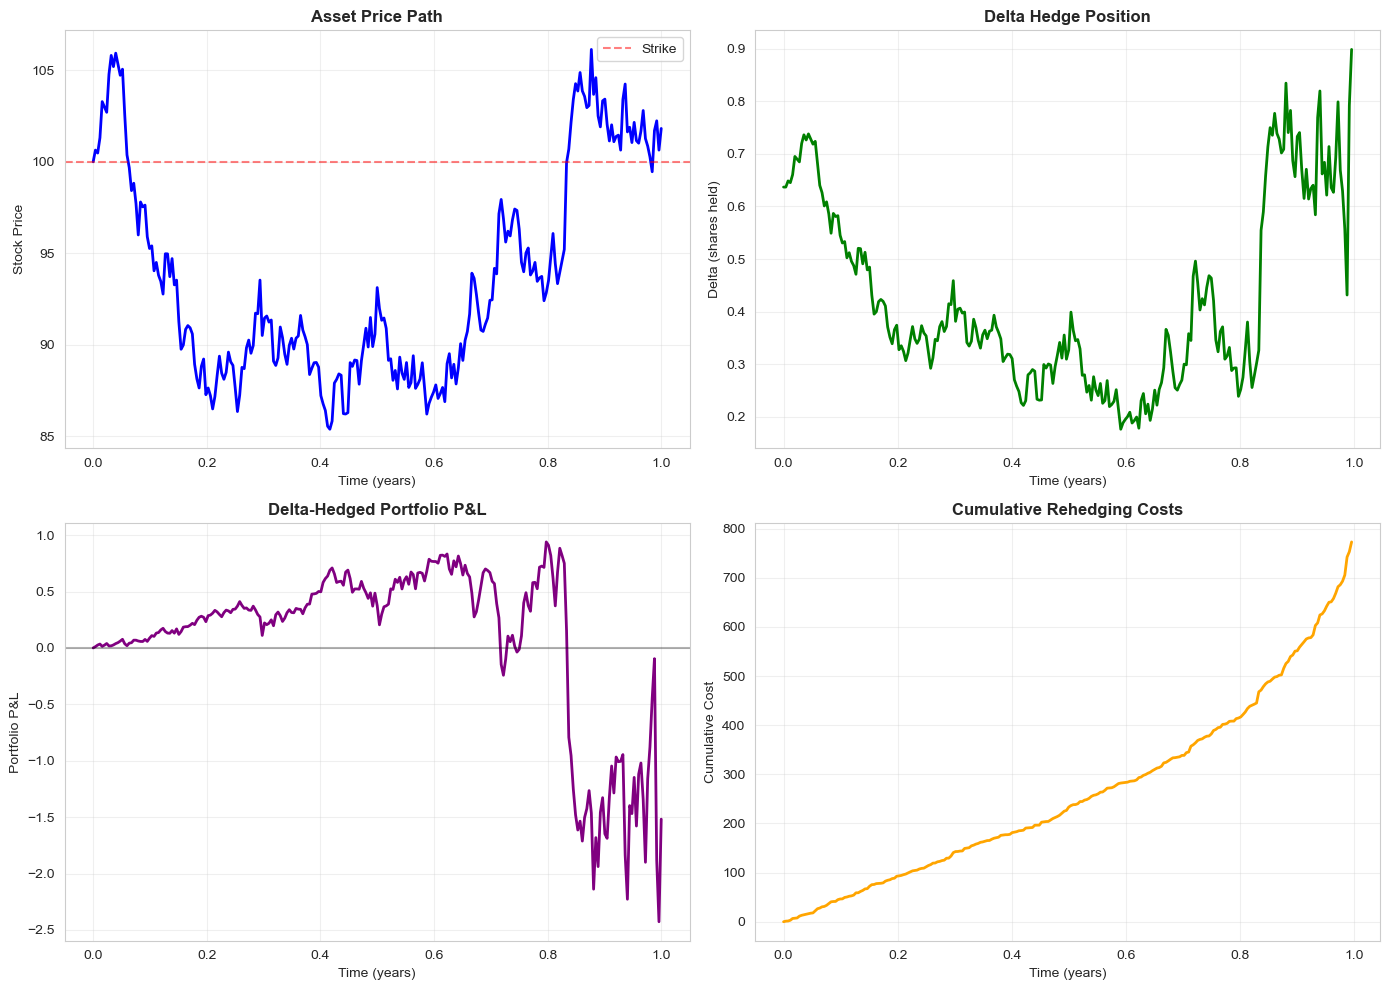

Final Portfolio P&L: $-1.5177
Total Rehedging Cost: $772.8426
P&L Std Dev: $0.7185


In [3]:
# Simulation parameters
S0 = 100.0
K = 100.0
T = 1.0
r = 0.05
sigma = 0.2
q = 0.0

n_steps = 252  # Daily rebalancing
n_paths = 1000

# Generate price paths
model = GBMModel(S0, r, sigma, q)
paths = model.simulate_paths(T, n_steps, n_paths, seed=42)

# Delta hedging on one sample path
sample_path = paths[0, :]
dt = T / n_steps
time_grid = np.linspace(0, T, n_steps + 1)

# Track portfolio value
portfolio_value = []
hedge_positions = []
rehedging_costs = []

# Initial setup: short 1 call, long delta shares
bs_init = BlackScholesPricer(sample_path[0], K, T, r, sigma, q)
delta_init = bs_init.delta('call')
call_price_init = bs_init.price('call')

# Portfolio: -call + delta*stock + cash
cash = call_price_init - delta_init * sample_path[0]
delta_position = delta_init

for i, (S_t, t) in enumerate(zip(sample_path, time_grid)):
    time_to_maturity = T - t
    
    if time_to_maturity > 0:
        # Calculate current delta
        bs_t = BlackScholesPricer(S_t, K, time_to_maturity, r, sigma, q)
        delta_t = bs_t.delta('call')
        call_price_t = bs_t.price('call')
        
        # Portfolio value before rehedging
        stock_value = delta_position * S_t
        cash_value = cash * np.exp(r * i * dt)
        portfolio_val = -call_price_t + stock_value + cash_value
        
        portfolio_value.append(portfolio_val)
        hedge_positions.append(delta_position)
        
        # Rehedge: adjust stock position
        if i < n_steps:
            shares_to_trade = delta_t - delta_position
            transaction_cost = abs(shares_to_trade) * S_t
            rehedging_costs.append(transaction_cost)
            
            # Update cash and position
            cash -= shares_to_trade * S_t
            delta_position = delta_t
    else:
        # At expiration
        payoff = max(S_t - K, 0)
        stock_value = delta_position * S_t
        cash_value = cash * np.exp(r * T)
        portfolio_val = -payoff + stock_value + cash_value
        portfolio_value.append(portfolio_val)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stock path
axes[0, 0].plot(time_grid, sample_path, 'b-', linewidth=2)
axes[0, 0].axhline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
axes[0, 0].set_xlabel('Time (years)')
axes[0, 0].set_ylabel('Stock Price')
axes[0, 0].set_title('Asset Price Path', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Delta position
axes[0, 1].plot(time_grid[:-1], hedge_positions, 'g-', linewidth=2)
axes[0, 1].set_xlabel('Time (years)')
axes[0, 1].set_ylabel('Delta (shares held)')
axes[0, 1].set_title('Delta Hedge Position', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Portfolio P&L
axes[1, 0].plot(time_grid, portfolio_value, 'purple', linewidth=2)
axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Time (years)')
axes[1, 0].set_ylabel('Portfolio P&L')
axes[1, 0].set_title('Delta-Hedged Portfolio P&L', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative rehedging costs
cumulative_costs = np.cumsum(rehedging_costs)
axes[1, 1].plot(time_grid[:-1], cumulative_costs, 'orange', linewidth=2)
axes[1, 1].set_xlabel('Time (years)')
axes[1, 1].set_ylabel('Cumulative Cost')
axes[1, 1].set_title('Cumulative Rehedging Costs', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Portfolio P&L: ${portfolio_value[-1]:.4f}")
print(f"Total Rehedging Cost: ${cumulative_costs[-1]:.4f}")
print(f"P&L Std Dev: ${np.std(portfolio_value):.4f}")

## 3. P&L Distribution Analysis

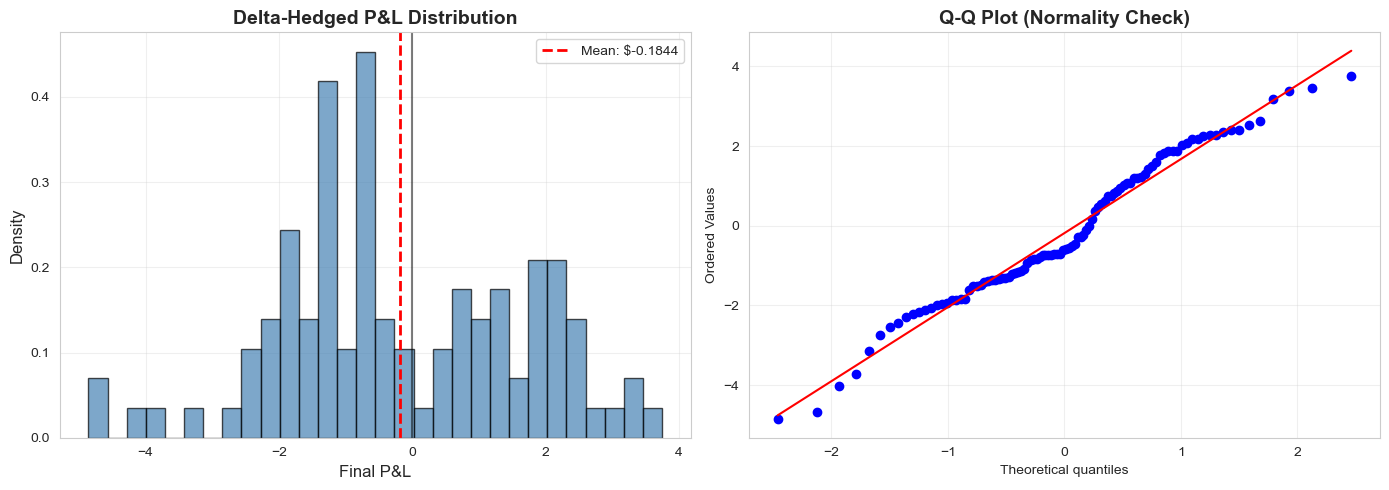

P&L Statistics:
  Mean:     $-0.184450
  Std Dev:  $1.841052
  Skewness: -0.0102
  Kurtosis: -0.4614


In [4]:
# Simulate P&L distribution across all paths
final_pnls = []

for path_idx in range(min(100, n_paths)):  # Limit for speed
    path = paths[path_idx, :]
    
    # Initial setup
    bs_init = BlackScholesPricer(path[0], K, T, r, sigma, q)
    delta_init = bs_init.delta('call')
    call_price_init = bs_init.price('call')
    
    cash = call_price_init - delta_init * path[0]
    delta_position = delta_init
    
    # Simulate hedging
    for i, (S_t, t) in enumerate(zip(path[:-1], time_grid[:-1])):
        time_to_maturity = T - t
        bs_t = BlackScholesPricer(S_t, K, time_to_maturity, r, sigma, q)
        delta_t = bs_t.delta('call')
        
        shares_to_trade = delta_t - delta_position
        cash -= shares_to_trade * S_t
        delta_position = delta_t
    
    # Final P&L
    S_T = path[-1]
    payoff = max(S_T - K, 0)
    stock_value = delta_position * S_T
    cash_value = cash * np.exp(r * T)
    final_pnl = -payoff + stock_value + cash_value
    final_pnls.append(final_pnl)

final_pnls = np.array(final_pnls)

# Plot distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(final_pnls, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(np.mean(final_pnls), color='red', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(final_pnls):.4f}')
ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
ax1.set_xlabel('Final P&L', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Delta-Hedged P&L Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(final_pnls, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"P&L Statistics:")
print(f"  Mean:     ${np.mean(final_pnls):.6f}")
print(f"  Std Dev:  ${np.std(final_pnls):.6f}")
print(f"  Skewness: {stats.skew(final_pnls):.4f}")
print(f"  Kurtosis: {stats.kurtosis(final_pnls):.4f}")

## 4. VaR and CVaR Analysis

Position Value: $461.50
Position Delta: 56.95 shares

RISK METRICS (1-Day, 95% Confidence)

Monte Carlo Method:
  VaR:  $112.43 (24.36%)
  CVaR: $136.54 (29.59%)

Parametric Method:
  VaR:  $118.76 (25.73%)
  CVaR: $148.92 (32.27%)


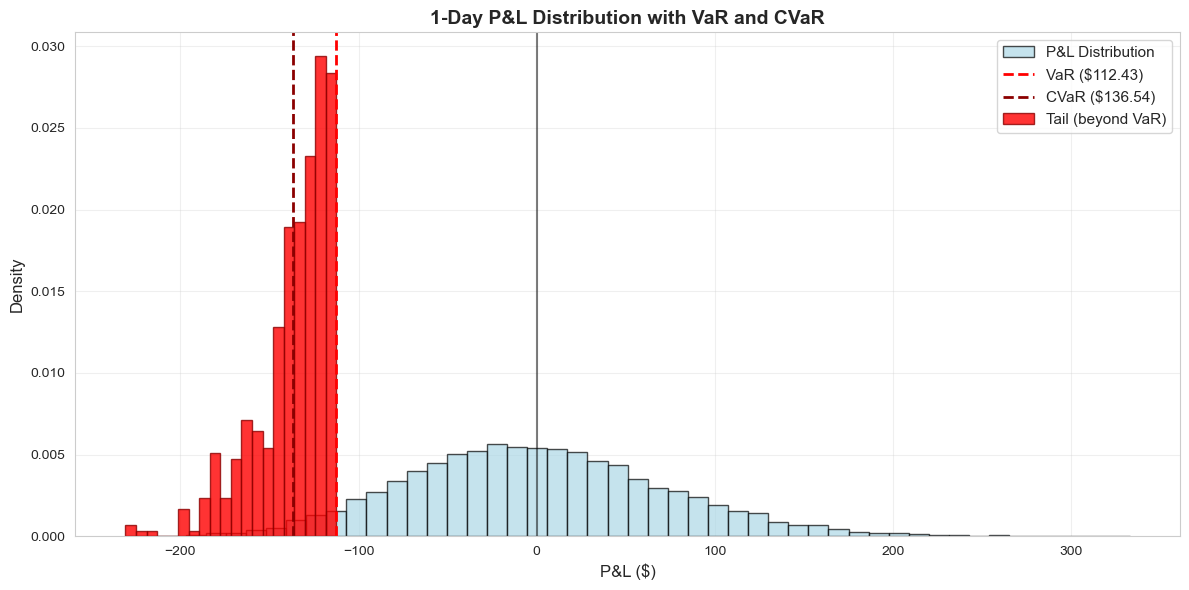

In [5]:
# Current option position
S_current = 100.0
bs_current = BlackScholesPricer(S_current, K, 0.25, r, sigma, q)  # 3 months to expiry
position_value = bs_current.price('call') * 100  # 100 contracts

print(f"Position Value: ${position_value:.2f}")
print(f"Position Delta: {bs_current.delta('call') * 100:.2f} shares")

# Simulate returns
n_scenarios = 10000
dt_risk = 1/252  # 1-day horizon

model_risk = GBMModel(S_current, r, sigma, q)
S_future = model_risk.simulate_terminal_prices(dt_risk, n_scenarios, seed=42)

# Calculate future option values
T_future = 0.25 - dt_risk
future_values = np.array([BlackScholesPricer(S, K, T_future, r, sigma, q).price('call') * 100 for S in S_future])

# Risk metrics
risk = RiskMetrics(position_value, confidence_level=0.95)

# Historical-style (using simulated scenarios)
var_hist = risk.var_monte_carlo(future_values)
cvar_hist = risk.cvar_monte_carlo(future_values)

# Parametric
returns = (future_values - position_value) / position_value
var_param = risk.var_parametric(np.mean(returns), np.std(returns))
cvar_param = risk.cvar_parametric(np.mean(returns), np.std(returns))

print("\n" + "="*50)
print("RISK METRICS (1-Day, 95% Confidence)")
print("="*50)
print(f"\nMonte Carlo Method:")
print(f"  VaR:  ${var_hist:.2f} ({var_hist/position_value*100:.2f}%)")
print(f"  CVaR: ${cvar_hist:.2f} ({cvar_hist/position_value*100:.2f}%)")

print(f"\nParametric Method:")
print(f"  VaR:  ${var_param:.2f} ({var_param/position_value*100:.2f}%)")
print(f"  CVaR: ${cvar_param:.2f} ({cvar_param/position_value*100:.2f}%)")
print("="*50)

# Visualize
pnl = future_values - position_value

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pnl, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black', label='P&L Distribution')
ax.axvline(-var_hist, color='red', linestyle='--', linewidth=2, label=f'VaR (${var_hist:.2f})')
ax.axvline(-cvar_hist, color='darkred', linestyle='--', linewidth=2, label=f'CVaR (${cvar_hist:.2f})')
ax.axvline(0, color='black', linestyle='-', alpha=0.5)

# Highlight tail region
tail_pnl = pnl[pnl <= -var_hist]
if len(tail_pnl) > 0:
    ax.hist(tail_pnl, bins=20, density=True, alpha=0.8, color='red', edgecolor='darkred', label='Tail (beyond VaR)')

ax.set_xlabel('P&L ($)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('1-Day P&L Distribution with VaR and CVaR', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Key Insights

**Greeks:**
- Delta changes with moneyness and time
- Gamma peaks at ATM near expiration (rehedging risk)
- Vega highest for ATM options with longer maturity
- Theta accelerates as expiration approaches

**Delta Hedging:**
- Perfect hedging requires continuous rebalancing (impossible)
- Discrete hedging leads to P&L variance (gamma risk)
- Rehedging costs accumulate over time

**Risk Metrics:**
- CVaR > VaR (captures tail risk)
- Monte Carlo captures non-normality
- Options have asymmetric risk profiles